Total Features Before Selection: 83

Updated Selected Features After Removal:
['Source Port', 'Flow Duration', 'Fwd Packet Length Std', 'Bwd Packet Length Max', 'Bwd Packet Length Mean', 'Bwd Packet Length Std', 'Flow IAT Std', 'Flow IAT Max', 'Fwd IAT Total', 'Fwd IAT Std', 'Fwd IAT Max', 'Bwd IAT Total', 'Bwd IAT Mean', 'Bwd IAT Std', 'Bwd IAT Max', 'Max Packet Length', 'Packet Length Std', 'Packet Length Variance', 'RST Flag Count', 'URG Flag Count', 'Avg Bwd Segment Size', 'Idle Mean', 'Idle Max', 'Idle Min', 'Inbound']

Total Features After Selection: 25


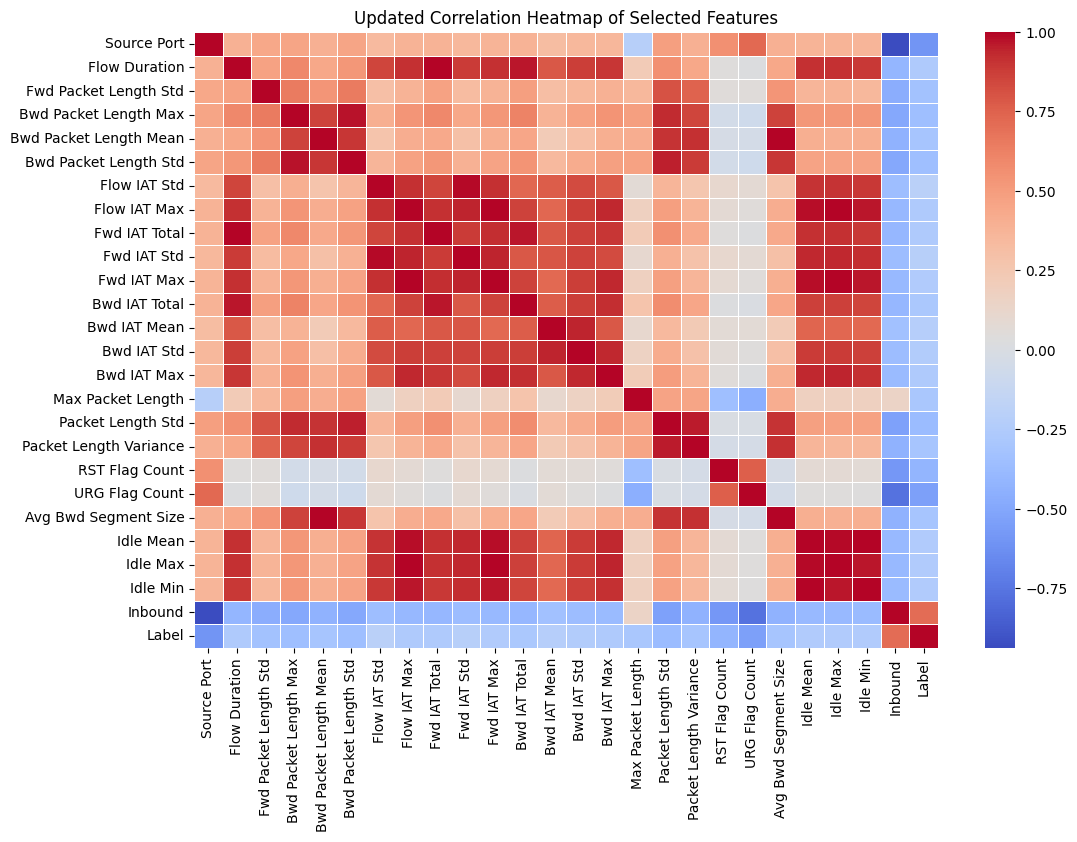

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder

# Load Dataset
file_path = "E:\\TLS_Balanced_Attacks_Fixed.csv"
tls_traffic = pd.read_csv(file_path)

# Clean column names (remove spaces)
tls_traffic.columns = tls_traffic.columns.str.strip()

# Identify the target column (attack type)
target_column = "Label"

# Convert categorical target variable (Label) to numerical for correlation analysis
label_encoder = LabelEncoder()
tls_traffic[target_column] = label_encoder.fit_transform(tls_traffic[target_column])

# Convert numeric columns to float32 for memory efficiency
numeric_cols = tls_traffic.select_dtypes(include=['float64', 'int64']).columns
tls_traffic[numeric_cols] = tls_traffic[numeric_cols].astype(np.float32)

# Print total number of features before selection
print(f"Total Features Before Selection: {tls_traffic.shape[1] - 2}")  # Excluding Label & Timestamp

# Compute Correlation Matrix
correlation_matrix = tls_traffic.corr(numeric_only=True)

# Compute correlation with target variable (Label)
target_correlation = correlation_matrix[target_column].drop(target_column, errors="ignore")

# Select features with correlation above a set threshold
correlation_threshold = 0.2
selected_features = target_correlation[abs(target_correlation) > correlation_threshold]

# Drop only unnecessary index columns (but KEEP Timestamp)
identifiers_to_remove = ['Unnamed: 0', 'CWE Flag Count', 'ACK Flag Count', 'Fwd PSH Flags']  # Removed unnecessary features
selected_features = selected_features.drop(index=identifiers_to_remove, errors='ignore')

# Print the selected features
print("\nUpdated Selected Features After Removal:")
print(selected_features.index.tolist())

# Print total number of selected features
print(f"\nTotal Features After Selection: {len(selected_features)}")

# Keep only selected features + Label + Timestamp
tls_traffic = tls_traffic[selected_features.index.tolist() + [target_column, "Timestamp"]]

# Define the output file path
output_file_path = "E:\\TLS_Selected_Features_Updated.csv"

# Save the processed dataset to CSV
tls_traffic.to_csv(output_file_path, index=False)

# Visualize correlation matrix for selected features
plt.figure(figsize=(12, 8))
sns.heatmap(tls_traffic.corr(numeric_only=True), annot=False, cmap="coolwarm", linewidths=0.5)
plt.title("Updated Correlation Heatmap of Selected Features")
plt.show()

In [2]:
from sklearn.preprocessing import OneHotEncoder

# Identify the target column
target_column = "Label"

# Initialize One-Hot Encoder
ohe = OneHotEncoder(sparse_output=False)  # Updated to avoid warning

# Apply One-Hot Encoding to "Label" column
encoded_labels = ohe.fit_transform(tls_traffic[[target_column]])

# Create column names for the new encoded classes
ohe_columns = ohe.get_feature_names_out([target_column])

# Convert encoded labels into a DataFrame
encoded_labels_df = pd.DataFrame(encoded_labels, columns=ohe_columns)

# Merge One-Hot Encoded Labels with the dataset (drop original Label column)
tls_traffic = pd.concat([tls_traffic.drop(columns=[target_column]), encoded_labels_df], axis=1)

# Define the output file path
output_file_path = "E:\\TLS_OneHotEncoded.csv"

# Save the processed dataset to CSV
tls_traffic.to_csv(output_file_path, index=False)

# Display dataset shape and new column names
print(f"Dataset shape after One-Hot Encoding: {tls_traffic.shape}")
print(f"New Columns After Encoding: {ohe_columns.tolist()}")
print(f"One-Hot Encoded dataset saved successfully at: {output_file_path}")

# Show first few rows to verify encoding
print(tls_traffic.head())

Dataset shape after One-Hot Encoding: (179032, 31)
New Columns After Encoding: ['Label_0', 'Label_1', 'Label_2', 'Label_3', 'Label_4']
One-Hot Encoded dataset saved successfully at: E:\TLS_OneHotEncoded.csv
   Source Port  Flow Duration  Fwd Packet Length Std  Bwd Packet Length Max  \
0        564.0           46.0                    0.0                    0.0   
1        564.0            1.0                    0.0                    0.0   
2        564.0           47.0                    0.0                    0.0   
3        864.0            1.0                    0.0                    0.0   
4        564.0            1.0                    0.0                    0.0   

   Bwd Packet Length Mean  Bwd Packet Length Std  Flow IAT Std  Flow IAT Max  \
0                     0.0                    0.0           0.0          46.0   
1                     0.0                    0.0           0.0           1.0   
2                     0.0                    0.0           0.0          47.0  

In [3]:
import pandas as pd
from sklearn.model_selection import train_test_split

# Identify the feature columns (excluding timestamp and label columns)
target_columns = [col for col in tls_traffic.columns if col.startswith("Label_")]
feature_columns = [col for col in tls_traffic.columns if col not in target_columns + ["Timestamp"]]

# First, split into Training (70%) and Remaining (30%)
X_train, X_rem, y_train, y_rem = train_test_split(
    tls_traffic[feature_columns], tls_traffic[target_columns], 
    test_size=0.3, random_state=42, stratify=tls_traffic[target_columns]
)

# Then, split the remaining 30% into Validation (15%) and Testing (15%)
X_val, X_test, y_val, y_test = train_test_split(
    X_rem, y_rem, 
    test_size=0.5, random_state=42, stratify=y_rem
)

# Print dataset shapes
print(f"Training Set Shape: {X_train.shape}, {y_train.shape}")
print(f"Validation Set Shape: {X_val.shape}, {y_val.shape}")
print(f"Testing Set Shape: {X_test.shape}, {y_test.shape}")

# Confirm Train/Val/Test Split Completed Successfully
print("Dataset splitting into Train (70%), Validation (15%), and Test (15%) is complete!")

Training Set Shape: (125322, 25), (125322, 5)
Validation Set Shape: (26855, 25), (26855, 5)
Testing Set Shape: (26855, 25), (26855, 5)
Dataset splitting into Train (70%), Validation (15%), and Test (15%) is complete!


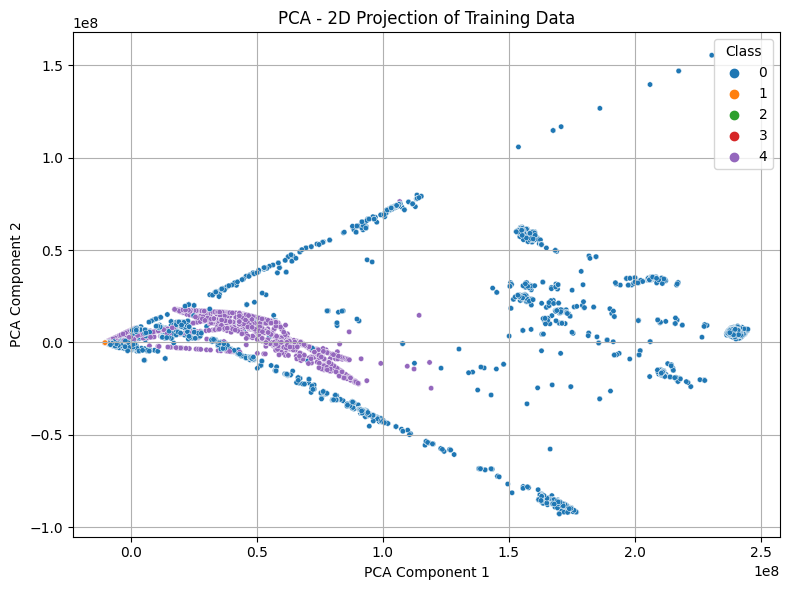

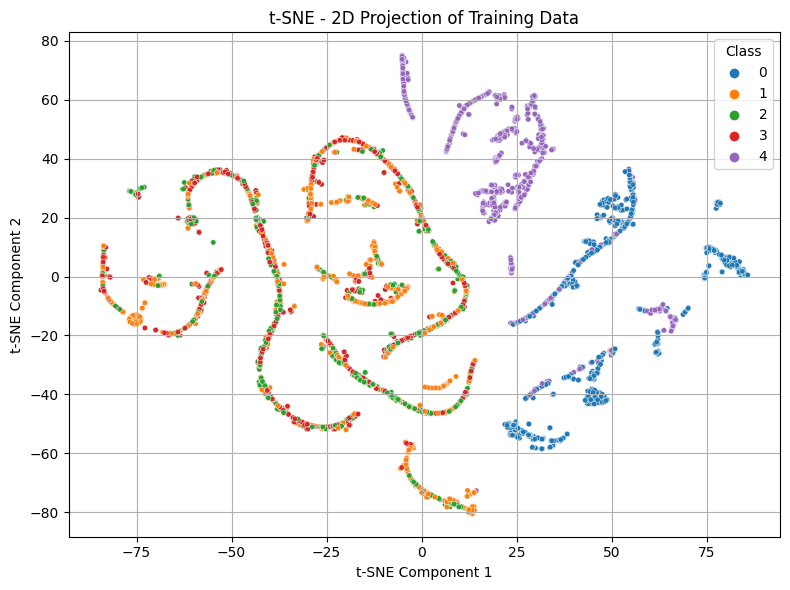

In [ ]:
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
import seaborn as sns

# Use integer labels for visualization
y_train_labels = y_train.idxmax(axis=1).apply(lambda x: int(x.split('_')[1]))

# ---------------------- PCA ----------------------
pca = PCA(n_components=2, random_state=42)
X_train_pca = pca.fit_transform(X_train)

# Plot PCA
plt.figure(figsize=(8, 6))
sns.scatterplot(x=X_train_pca[:, 0], y=X_train_pca[:, 1], hue=y_train_labels, palette="tab10", s=15)
plt.title("PCA - 2D Projection of Training Data")
plt.xlabel("PCA Component 1")
plt.ylabel("PCA Component 2")
plt.legend(title='Class', loc='best')
plt.grid(True)
plt.tight_layout()
plt.show()

# ---------------------- t-SNE ----------------------
# Note: t-SNE is computationally heavy. Consider sampling if dataset is large
sample_size = 5000  # Optional: reduce for speed
X_sample = X_train[:sample_size]
y_sample_labels = y_train_labels[:sample_size]

tsne = TSNE(n_components=2, perplexity=30, n_iter=1000, learning_rate='auto', init='pca', random_state=42)
X_train_tsne = tsne.fit_transform(X_sample)

# Plot t-SNE
plt.figure(figsize=(8, 6))
sns.scatterplot(x=X_train_tsne[:, 0], y=X_train_tsne[:, 1], hue=y_sample_labels, palette="tab10", s=15)
plt.title("t-SNE - 2D Projection of Training Data")
plt.xlabel("t-SNE Component 1")
plt.ylabel("t-SNE Component 2")
plt.legend(title='Class', loc='best')
plt.grid(True)
plt.tight_layout()
plt.show()

In [6]:
import os
import warnings
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'
warnings.filterwarnings("ignore")

import pennylane as qml
import tensorflow as tf
import numpy as np
from sklearn.model_selection import train_test_split
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping


# -------------------------------
# Step 1: Quantum Configuration
# -------------------------------
num_qubits = 6
amplitude_embedding_length = 2 ** num_qubits  # 64 features required

# Padding function for amplitude embedding
def pad_input(x, target_len=amplitude_embedding_length):
    return np.pad(x, (0, target_len - len(x)), mode='constant')

# Extract and pad quantum features
quantum_raw = np.array(X_train.iloc[:, :num_qubits], dtype=np.float32)
quantum_features = np.array([pad_input(x) for x in quantum_raw], dtype=np.float32)

# Classical features (remaining)
classical_features = np.array(X_train.iloc[:, num_qubits:], dtype=np.float32)
y_train = np.array(y_train, dtype=np.float32)

# -------------------------------
# Step 2: Quantum Circuit
# -------------------------------
dev = qml.device("default.qubit.tf", wires=num_qubits)

@qml.qnode(dev, interface="tf")
def quantum_circuit(inputs, weights):
    inputs = tf.reshape(inputs, (-1,))
    for i in range(num_qubits):
        qml.Hadamard(wires=i)
    qml.AmplitudeEmbedding(inputs, wires=range(num_qubits), normalize=True, pad_with=0.0)
    qml.StronglyEntanglingLayers(weights, wires=range(num_qubits))
    return [qml.expval(qml.PauliZ(i)) for i in range(num_qubits)]

class QuantumLayer(tf.keras.layers.Layer):
    def __init__(self, num_qubits, **kwargs):
        super().__init__(**kwargs)
        self.num_qubits = num_qubits
        self.q_weights = self.add_weight(
            name="q_weights",
            shape=(4, num_qubits, 3),
            initializer=tf.keras.initializers.RandomUniform(minval=0.0, maxval=2 * np.pi),
            trainable=True
        )

    def call(self, inputs):
        def quantum_fn(x):
            return tf.convert_to_tensor(quantum_circuit(x, self.q_weights), dtype=tf.float32)
        return tf.reshape(tf.map_fn(quantum_fn, inputs, dtype=tf.float32), (-1, self.num_qubits))

# -------------------------------
# Step 3: Hybrid Model Definition
# -------------------------------
def create_hybrid_model(num_qubits, num_features, num_classes=5):
    input_q = tf.keras.layers.Input(shape=(amplitude_embedding_length,))
    input_c = tf.keras.layers.Input(shape=(num_features - num_qubits,))
    
    q_layer = QuantumLayer(num_qubits)(input_q)
    q_layer = tf.keras.layers.Dense(128, activation="relu")(q_layer)
    q_layer = tf.keras.layers.BatchNormalization()(q_layer)
    q_layer = tf.keras.layers.Dropout(0.3)(q_layer)

    c_layer = tf.keras.layers.Dense(256, activation="relu")(input_c)
    c_layer = tf.keras.layers.BatchNormalization()(c_layer)
    c_layer = tf.keras.layers.Dropout(0.4)(c_layer)
    c_layer = tf.keras.layers.Dense(128, activation="relu")(c_layer)
    c_layer = tf.keras.layers.BatchNormalization()(c_layer)
    c_layer = tf.keras.layers.Dropout(0.4)(c_layer)

    combined = tf.keras.layers.concatenate([q_layer, c_layer])
    combined = tf.keras.layers.Dense(128, activation="relu")(combined)
    combined = tf.keras.layers.BatchNormalization()(combined)
    combined = tf.keras.layers.Dropout(0.3)(combined)

    output = tf.keras.layers.Dense(num_classes, activation="softmax")(combined)
    model = tf.keras.models.Model(inputs=[input_q, input_c], outputs=output)
    return model

# -------------------------------
# Step 4: Compile and Train
# -------------------------------
hybrid_model = create_hybrid_model(num_qubits, X_train.shape[1])
hybrid_model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.0005),
    loss="categorical_crossentropy",
    metrics=["accuracy", tf.keras.metrics.Precision(name="precision"), tf.keras.metrics.Recall(name="recall")]
)

# Train-validation split
X_train_q, X_val_q, X_train_c, X_val_c, y_train_split, y_val_split = train_test_split(
    quantum_features, classical_features, y_train,
    test_size=0.2, random_state=42, stratify=y_train
)

# Custom Data Generator
class CustomBatchGenerator(tf.keras.utils.Sequence):
    def __init__(self, X_q, X_c, y, batch_size):
        self.X_q = np.array(X_q, dtype=np.float32)
        self.X_c = np.array(X_c, dtype=np.float32)
        self.y = np.array(y, dtype=np.float32)
        self.batch_size = batch_size

    def __len__(self):
        return int(np.ceil(len(self.y) / self.batch_size))

    def __getitem__(self, idx):
        batch_X_q = self.X_q[idx * self.batch_size:(idx + 1) * self.batch_size]
        batch_X_c = self.X_c[idx * self.batch_size:(idx + 1) * self.batch_size]
        batch_y = self.y[idx * self.batch_size:(idx + 1) * self.batch_size]
        return [batch_X_q, batch_X_c], batch_y

train_generator = CustomBatchGenerator(X_train_q, X_train_c, y_train_split, batch_size=64)
val_generator = CustomBatchGenerator(X_val_q, X_val_c, y_val_split, batch_size=64)

# Callbacks
lr_scheduler = ReduceLROnPlateau(monitor="val_loss", factor=0.5, patience=3, min_lr=1e-5)
early_stopping = EarlyStopping(monitor="val_accuracy", patience=5, restore_best_weights=True)

# Train the model
history = hybrid_model.fit(
    train_generator,
    validation_data=val_generator,
    epochs=30,
    verbose=1,
    callbacks=[lr_scheduler, early_stopping]
)

Epoch 1/30
  52/1567 [..............................] - ETA: 3:55 - loss: 1.3231 - accuracy: 0.4330 - precision: 0.4949 - recall: 0.2909

KeyboardInterrupt: 